Local Fastpath Example
----------------------

Communication between two containers needs to be encrypted by default, but this is wasteful if they are on the same machine.

#### Goals
- show that negotiation can help us take advantage of locality to avoid expensive processing.

#### Experiment

Encryption via Ghostunnel (GT), accessed via uds.

- 'encr': `container 1 --(uds)-- GT --(tls+tcp)-- GT --(uds)-- container 2`
  - with GT, with reliability, without fastpath chunnel
- 'rel': `container 1 --(udp)-- container 2`
  - no GT, with reliability, without fastpath chunnel
- 'fp-rel': `container 1 --(uds)-- container 2` 
  - no GT, with reliability, with fastpath chunnel 
  - same as 'rel' if remote
- 'fp': `container 1 --(uds)-- container 2` 
  - yes GT, yes reliability, yes fastpath chunnel
  - same as 'encr' if remote


200 connections, 10 rpcs per connection
- respond immediately

Data files:
`{local|remote}-mode:{encr|rel|fp}-msgs:200-perconn:10.data`

In [1]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import pandas as pd
import numpy as np

%config IPCompleter.greedy=True

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

In [125]:
pos = ['local']
mode = [f'mode:{m}' for m in ['encr', 'rel', 'rel-ux', 'fp', 'fp-rel']]
msgs = ['msgs:500']
perconn = ['perconn:10']
neg = [f'neg:{x}' for x in ['one', 'zero']]
version = ['~/burrito-local-rpcs/z-neg-comp-notrace']


In [126]:
df = None
for d in version:
    for p in pos:
        for m in mode:
            for nummsg in msgs:
                for pc in perconn:
                    for n in neg:
                        fn = f"{d}/{p}-{m}-{nummsg}-{pc}-{n}.data"
                        try:
                            file_df = pd.read_csv(fn, sep=",")
                        except:
                            print(fn)
                            continue
                        file_df['reliable'] = d
                        file_df['location'] = p
                        file_df['mode'] = m
                        file_df['nummsg'] = nummsg
                        file_df['perconn'] = pc
                        file_df['withneg'] = n
                        if df is None:
                            df = file_df
                        else:
                            df = df.append(file_df)
                    
df

,Conn_idx,Conn_time_us,Req_idx,Elapsed_us,Total_us,Server_us,reliable,location,mode,nummsg,perconn,withneg
0,0,23357,0,124563,4843,0,~/burrito-local-rpcs/z-neg-comp-notrace,local,mode:encr,msgs:500,perconn:10,neg:one
1,0,23357,1,129408,285,0,~/burrito-local-rpcs/z-neg-comp-notrace,local,mode:encr,msgs:500,perconn:10,neg:one
2,0,23357,2,129694,251,0,~/burrito-local-rpcs/z-neg-comp-notrace,local,mode:encr,msgs:500,perconn:10,neg:one
3,0,23357,3,129946,246,0,~/burrito-local-rpcs/z-neg-comp-notrace,local,mode:encr,msgs:500,perconn:10,neg:one
4,0,23357,4,130194,246,0,~/burrito-local-rpcs/z-neg-comp-notrace,local,mode:encr,msgs:500,perconn:10,neg:one
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,499,302,5,52019979,160,0,~/burrito-local-rpcs/z-neg-comp-notrace,local,mode:fp-rel,msgs:500,perconn:10,neg:zero
4996,499,302,6,52020140,157,0,~/burrito-local-rpcs/z-neg-comp-notrace,local,mode:fp-rel,msgs:500,perconn:10,neg:zero
4997,499,302,7,52020298,158,0,~/burrito-local-rpcs/z-neg-comp-notrace,local,mode:fp-rel,msgs:500,perconn:10,neg:zero
4998,499,302,8,52020458,157,0,~/burrito-local-rpcs/z-neg-comp-notrace,local,mode:fp-rel,msgs:500,perconn:10,neg:zero


In [6]:
df.to_csv("./local-fastpath-data.csv")

# Original Graph

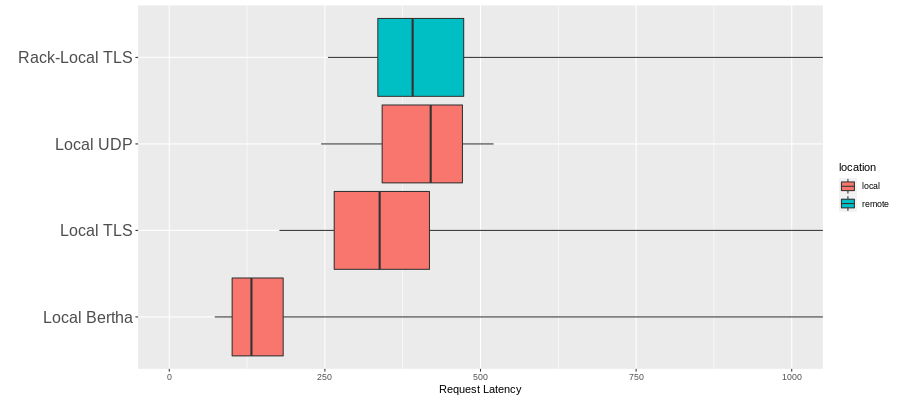

In [7]:
%%R -i df -w 900 -h 400

f <- function(x) {
  r <- quantile(x, probs = c(0.05, 0.25, 0.5, 0.75, 0.95))
  names(r) <- c("ymin", "lower", "middle", "upper", "ymax")
  r
}

norel <- df[df$reliable=="no-rel",]
ggplot(norel, aes(x=interaction(mode, location), y=Total_us, fill=location)) + 
  stat_summary(fun.data = f, geom="boxplot") + 
  scale_x_discrete(
      limits=c("mode:fp.local", "mode:encr.local", "mode:rel.local", "mode:fp.remote"),
      labels=c(
          "mode:fp.local" = "Local Bertha",
          "mode:encr.local" = "Local TLS",
          "mode:rel.local" = "Local UDP",
          "mode:fp.remote" = "Rack-Local TLS"
      )
  ) +
  xlab("") + ylab("Request Latency") +
  theme(
      axis.text.y = element_text(size=16)
  ) +
  coord_flip(ylim=c(0,1000))
#  stat_ecdf() +
#  scale_colour_discrete(limits=c("mode:fp.local", "mode:rel.local", "mode:encr.local", "mode:fp.remote")) +

# Other Graphs

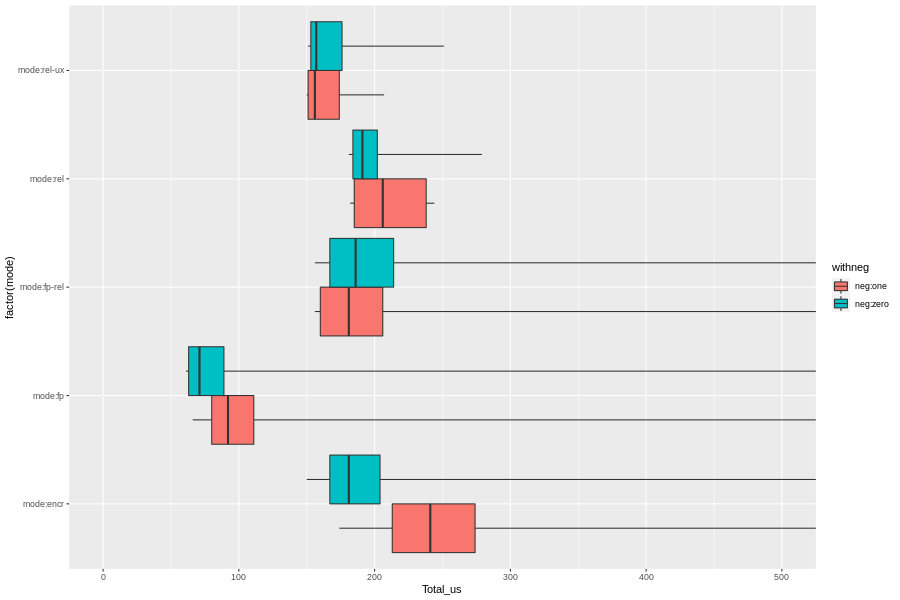

In [127]:
%%R -i df -w 900 -h 600

library(ggplot2)

f <- function(x) {
  r <- quantile(x, probs = c(0.05, 0.25, 0.5, 0.75, 0.95))
  names(r) <- c("ymin", "lower", "middle", "upper", "ymax")
  r
}

ggplot(df, aes(x=factor(mode), y=Total_us, fill=withneg)) + 
  stat_summary(fun.data = f, geom="boxplot", position="dodge") + 
  coord_flip(ylim=c(0,500))

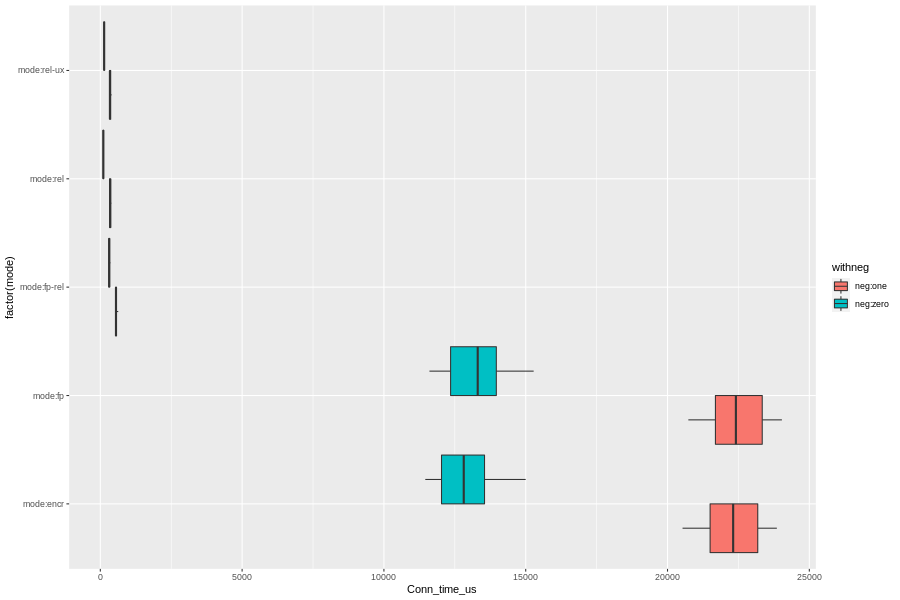

In [130]:
%%R -i df -w 900 -h 600

f <- function(x) {
  r <- quantile(x, probs = c(0.05, 0.25, 0.5, 0.75, 0.95))
  names(r) <- c("ymin", "lower", "middle", "upper", "ymax")
  r
}

ggplot(df, aes(x=factor(mode), y=Conn_time_us, fill=withneg)) +
  stat_summary(fun.data = f, geom="boxplot", position="dodge") + 
  coord_flip()

In [91]:
def parse_trace(fn):
    with open(fn) as f:
        for line in f:
            sp = line.split(":")
            if len(sp) != 4:
                continue
            grp, ev, _, nums = sp
            ev = ev.split('(')[0].strip().replace(' ', '_')
            grp = grp.split(' ')[-1]
            ev = f"{grp}::{ev}"
            flds = ['min', 'p25', 'p50', 'p75', 'p95', 'max', 'cnt']
            n = [int(x) for x in nums.strip().split()]
            if len(n) != len(flds):
                print(f"{n} != {flds}")
                continue
            flds = {x:y for x, y in zip(flds, n)}
            flds['event'] = ev
            yield flds
            

In [119]:
df_trace = None
from os.path import expanduser
for d in version:
    d = expanduser(d)
    for p in pos:
        for m in mode:
            for nummsg in msgs:
                for pc in perconn:
                    for n in neg:
                        fn = f"{d}/{p}-{m}-{nummsg}-{pc}-{n}.trace"
                        try:
                            file_df = pd.DataFrame.from_records(parse_trace(fn))
                        except Exception as e:
                            print(f"skip {fn}: {e}")
                            continue
                        file_df['reliable'] = d
                        file_df['location'] = p
                        file_df['mode'] = m
                        file_df['nummsg'] = nummsg
                        file_df['perconn'] = pc
                        file_df['withneg'] = n
                        if df_trace is None:
                            df_trace = file_df
                        else:
                            df_trace = df_trace.append(file_df)
                    
df_trace

skip /home/akshayn/burrito-local-rpcs/z-neg-comp-ux/local-mode:encr-msgs:500-perconn:10-neg:one.trace: [Errno 2] No such file or directory: '/home/akshayn/burrito-local-rpcs/z-neg-comp-ux/local-mode:encr-msgs:500-perconn:10-neg:one.trace'
skip /home/akshayn/burrito-local-rpcs/z-neg-comp-ux/local-mode:encr-msgs:500-perconn:10-neg:zero.trace: [Errno 2] No such file or directory: '/home/akshayn/burrito-local-rpcs/z-neg-comp-ux/local-mode:encr-msgs:500-perconn:10-neg:zero.trace'
skip /home/akshayn/burrito-local-rpcs/z-neg-comp-ux/local-mode:rel-msgs:500-perconn:10-neg:one.trace: [Errno 2] No such file or directory: '/home/akshayn/burrito-local-rpcs/z-neg-comp-ux/local-mode:rel-msgs:500-perconn:10-neg:one.trace'
skip /home/akshayn/burrito-local-rpcs/z-neg-comp-ux/local-mode:rel-msgs:500-perconn:10-neg:zero.trace: [Errno 2] No such file or directory: '/home/akshayn/burrito-local-rpcs/z-neg-comp-ux/local-mode:rel-msgs:500-perconn:10-neg:zero.trace'
skip /home/akshayn/burrito-local-rpcs/z-neg-

,min,p25,p50,p75,p95,max,cnt,event,reliable,location,mode,nummsg,perconn,withneg
0,23424,131071,158719,161791,179199,210943,500,which=2::recv,/home/akshayn/burrito-local-rpcs/z-neg-comp-ux,local,mode:rel-ux,msgs:500,perconn:10,neg:one
1,5728,14655,14847,15103,22527,42239,500,"which=2::""close""",/home/akshayn/burrito-local-rpcs/z-neg-comp-ux,local,mode:rel-ux,msgs:500,perconn:10,neg:one
2,2096,5375,5471,5695,6847,24319,500,which=6::send,/home/akshayn/burrito-local-rpcs/z-neg-comp-ux,local,mode:rel-ux,msgs:500,perconn:10,neg:one
3,12992,33535,33791,35071,41471,58879,500,"which=6::""close""",/home/akshayn/burrito-local-rpcs/z-neg-comp-ux,local,mode:rel-ux,msgs:500,perconn:10,neg:one
4,26880,136191,161791,164863,180223,248831,500,which=1::recv,/home/akshayn/burrito-local-rpcs/z-neg-comp-ux,local,mode:rel-ux,msgs:500,perconn:10,neg:one
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,7136,14527,14783,23423,24191,41471,500,"which=5::""close""",/home/akshayn/burrito-local-rpcs/z-neg-comp-ux,local,mode:rel-ux,msgs:500,perconn:10,neg:zero
82,27648,117247,127487,130047,143359,194559,500,which=4::recv,/home/akshayn/burrito-local-rpcs/z-neg-comp-ux,local,mode:rel-ux,msgs:500,perconn:10,neg:zero
83,8096,14527,14783,23423,24319,102399,500,"which=4::""close""",/home/akshayn/burrito-local-rpcs/z-neg-comp-ux,local,mode:rel-ux,msgs:500,perconn:10,neg:zero
84,31232,117759,127999,130047,144383,198655,500,which=3::recv,/home/akshayn/burrito-local-rpcs/z-neg-comp-ux,local,mode:rel-ux,msgs:500,perconn:10,neg:zero


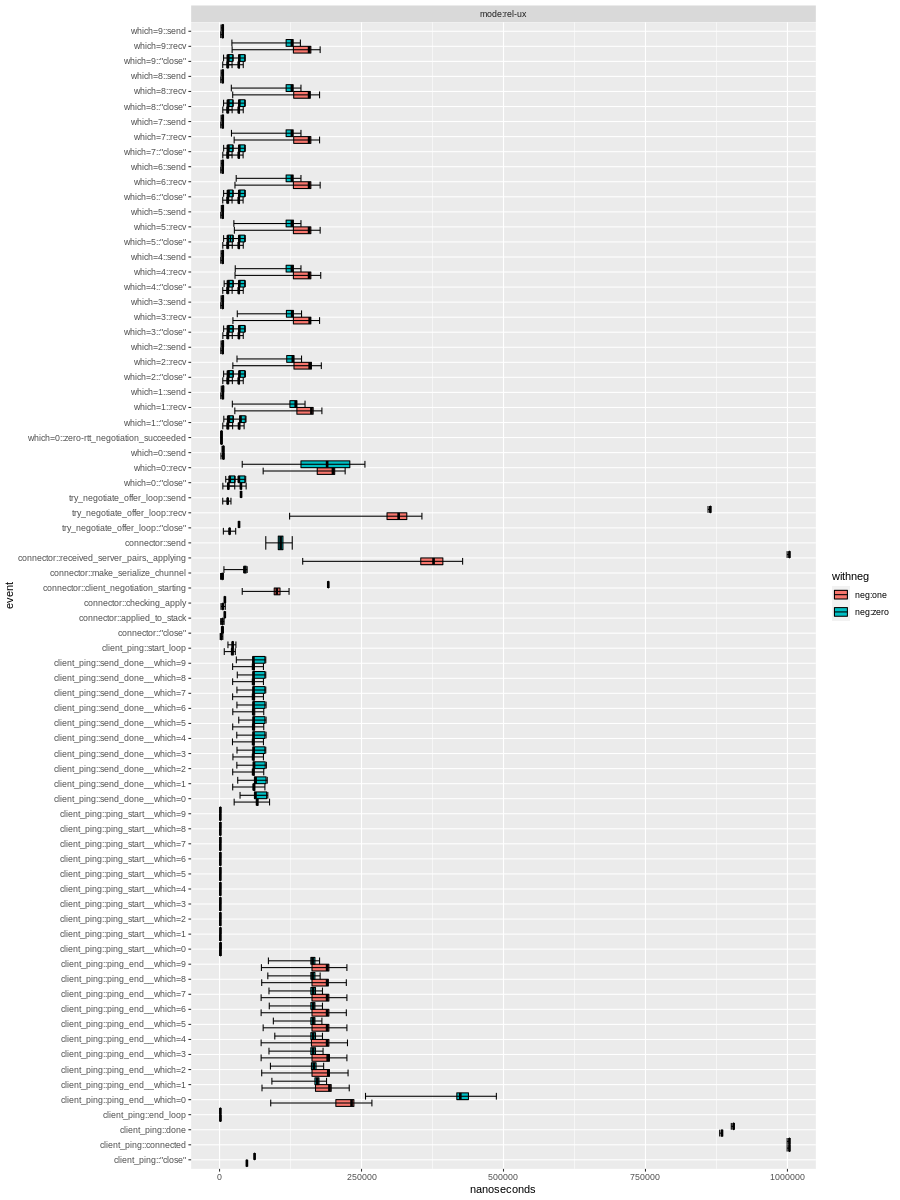

In [120]:
%%R -i df_trace -w 900 -h 1200

ggplot(df_trace[df_trace$mode == 'mode:rel-ux',], aes(x=event, fill=withneg)) +
  geom_crossbar(aes(ymin=p25, y=p50, ymax=p75), position="dodge") + 
  geom_errorbar(aes(ymin=min, ymax=p95), position="dodge") +
  facet_wrap(~mode, ncol=1) +
  ylab("nanoseconds") +
  coord_flip(ylim=c(0, 1000e3)) 

Unix Latencies

quantiles p25, p50, p75, p95, all in us

docker:
with trace: [311, 338, 368, 418]
no trace: [201, 231, 283, 377]

no docker:
no trace: [184, 228, 289, 347]

script (docker):
trace: [437, 470, 501, 560]
no prints: [265, 302, 409, 440]

In [107]:
srv_df_trace = None
for d in version:
    d = expanduser(d)
    for p in pos:
        for m in mode:
            for nummsg in msgs:
                for pc in perconn:
                    for n in neg:
                        fn = f"{d}/{p}-{m}-{nummsg}-{pc}-{n}.srvtrace"
                        try:
                            file_df = pd.DataFrame.from_records(parse_trace(fn))
                        except:
                            print(f"skip {fn}")
                            continue
                        file_df['reliable'] = d
                        file_df['location'] = p
                        file_df['mode'] = m
                        file_df['nummsg'] = nummsg
                        file_df['perconn'] = pc
                        file_df['withneg'] = n
                        if srv_df_trace is None:
                            srv_df_trace = file_df
                        else:
                            srv_df_trace = srv_df_trace.append(file_df)
                    
srv_df_trace.head()

skip /home/akshayn/burrito-local-rpcs/z-neg-comp-ux/local-mode:encr-msgs:500-perconn:10-neg:one.srvtrace
skip /home/akshayn/burrito-local-rpcs/z-neg-comp-ux/local-mode:encr-msgs:500-perconn:10-neg:zero.srvtrace
skip /home/akshayn/burrito-local-rpcs/z-neg-comp-ux/local-mode:rel-msgs:500-perconn:10-neg:one.srvtrace
skip /home/akshayn/burrito-local-rpcs/z-neg-comp-ux/local-mode:rel-msgs:500-perconn:10-neg:zero.srvtrace
skip /home/akshayn/burrito-local-rpcs/z-neg-comp-ux/local-mode:fp-msgs:500-perconn:10-neg:one.srvtrace
skip /home/akshayn/burrito-local-rpcs/z-neg-comp-ux/local-mode:fp-msgs:500-perconn:10-neg:zero.srvtrace
skip /home/akshayn/burrito-local-rpcs/z-neg-comp-ux/local-mode:fp-rel-msgs:500-perconn:10-neg:one.srvtrace
skip /home/akshayn/burrito-local-rpcs/z-neg-comp-ux/local-mode:fp-rel-msgs:500-perconn:10-neg:zero.srvtrace


,min,p25,p50,p75,p95,max,cnt,event,reliable,location,mode,nummsg,perconn,withneg
0,5728,8639,8831,9023,9535,17151,500,connection::New_connection,/home/akshayn/burrito-local-rpcs/z-neg-comp-ux,local,mode:rel-ux,msgs:500,perconn:10,neg:one
1,93184,221183,223231,238591,255999,1003519,5000,connection::got_req,/home/akshayn/burrito-local-rpcs/z-neg-comp-ux,local,mode:rel-ux,msgs:500,perconn:10,neg:one
2,1360,2415,2479,2559,2911,20223,5000,connection::sending_resp,/home/akshayn/burrito-local-rpcs/z-neg-comp-ux,local,mode:rel-ux,msgs:500,perconn:10,neg:one
3,999424,1003519,1003519,1003519,1003519,1003519,492,connection::Connection_timing_out,/home/akshayn/burrito-local-rpcs/z-neg-comp-ux,local,mode:rel-ux,msgs:500,perconn:10,neg:one
4,5984,18687,19327,20223,22655,28287,492,connection::close,/home/akshayn/burrito-local-rpcs/z-neg-comp-ux,local,mode:rel-ux,msgs:500,perconn:10,neg:one


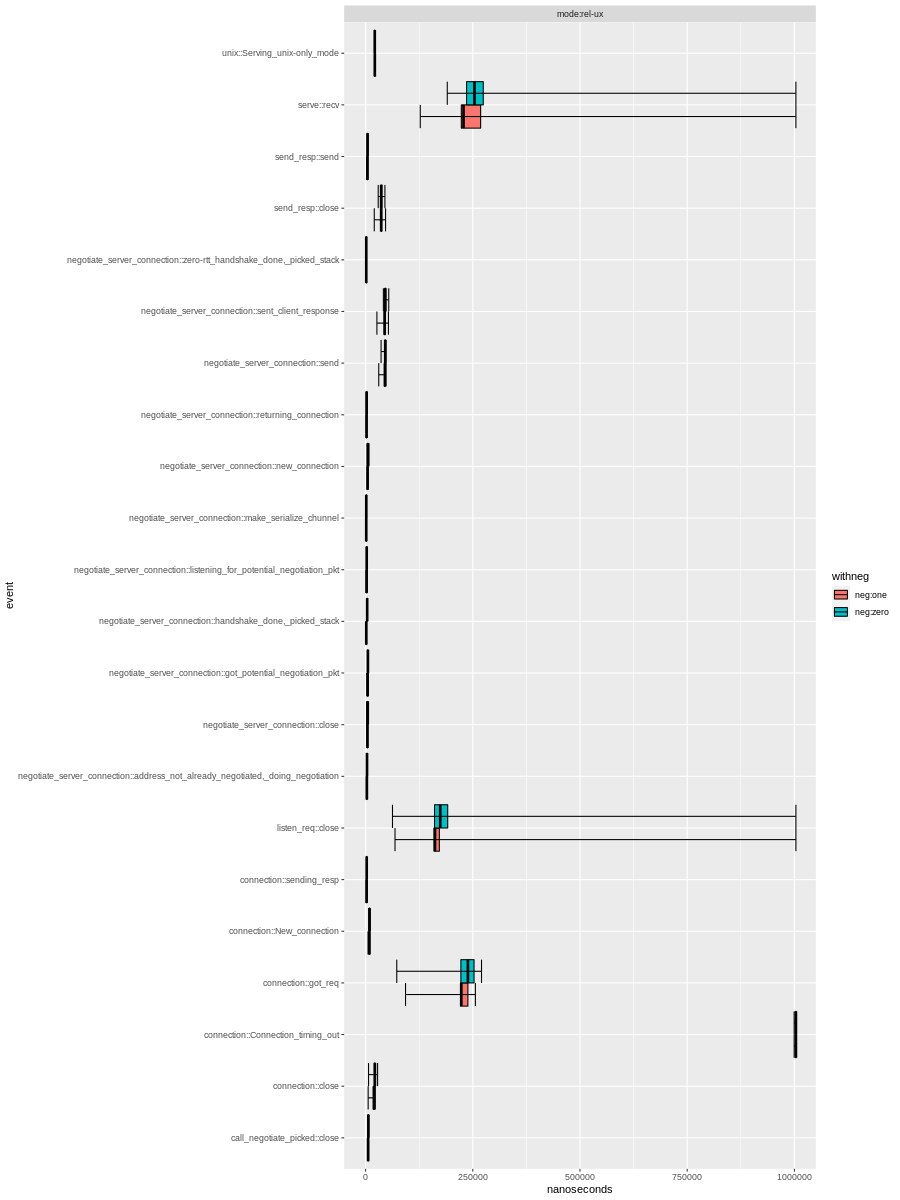

In [108]:
%%R -i srv_df_trace -w 900 -h 1200

ggplot(srv_df_trace[srv_df_trace$mode=='mode:rel-ux',], aes(x=event, fill=withneg)) +
  geom_crossbar(aes(ymin=p25, y=p50, ymax=p75), position="dodge") + 
  geom_errorbar(aes(ymin=min, ymax=p95), position="dodge") +
  facet_wrap(~mode, ncol=1) +
  ylab("nanoseconds") +
  coord_flip(ylim=c(0, 1000e3))